In [317]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.distributions import Normal
from torch.distributions import StudentT
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import math
from scipy.stats import norm
from collections import defaultdict
from random import uniform
from tqdm import tqdm
import scipy.stats

In [318]:
class SpatioTemporalCausalAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_assets, num_timesteps):
        super().__init__()
        self.embed = nn.Linear(input_dim, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.output_proj = nn.Linear(embed_dim, embed_dim)
        self.num_assets = num_assets
        self.num_timesteps = num_timesteps

        # Precompute causal time mask
        t = num_timesteps
        a = num_assets
        time_ids = torch.arange(t).repeat(a)  # [A*T]
        mask = time_ids[None, :] <= time_ids[:, None]
        self.register_buffer("causal_mask", (~mask).float() * float('-inf'))  # [A*T, A*T]

    def forward(self, x):
        B, A, T, V = x.shape
        x = x.permute(0, 2, 1, 3).reshape(B, A*T, V)  # [B, A*T, V]
        x = self.embed(x)
    
        # Recreate the mask dynamically in case T is variable
        time_ids = torch.arange(T, device=x.device).repeat(A)
        mask = time_ids[None, :] <= time_ids[:, None]
        causal_mask = (~mask).float() * float('-1e9')  # [A*T, A*T]
    
        attn_out, _ = self.attn(x, x, x, attn_mask=causal_mask)
        x_proj = self.output_proj(attn_out)
        #nn.init.xavier_uniform_(self.output_proj.weight)
        #self.output_proj.bias.data.zero_()
        return x_proj.reshape(B, T, A, -1).permute(0, 2, 1, 3)  # [B, A, T, E]

In [319]:
class MultiTimescaleLSTM(nn.Module):
    def __init__(self, asset_size, h_size, n_layers, batch_size, max_seq_len,
                 pre_heads, time_heads, asset_heads, meta_heads,
                 value_size, num_lstms, dropout=0.0):
        super().__init__()

        self.asset_out_size = asset_size
        self.value_size = value_size
        self.h_size = h_size
        self.num_lstms = num_lstms
        self.max_seq_len = max_seq_len

        # === Attention Modules ===
        self.spatio_temporal_attn = SpatioTemporalCausalAttention(
            input_dim=value_size,
            embed_dim=h_size,
            num_heads=pre_heads,
            num_assets=asset_size,
            num_timesteps=max_seq_len
        )

        self.temporal_attn = nn.MultiheadAttention(embed_dim=h_size, num_heads=time_heads, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(embed_dim=h_size, num_heads=asset_heads, batch_first=True)
        self.meta_attn = nn.MultiheadAttention(embed_dim=num_lstms, num_heads=meta_heads, batch_first=True)

        # === LSTM ===
        self.lstm = nn.LSTM(
            input_size=asset_size * h_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True
        )

        # === Linear Layers ===
        self.post_fc = nn.Linear(asset_size * h_size, 4 * asset_size)
        self.meta_fc = nn.Linear(4 * asset_size * num_lstms, 4 * asset_size)

    def forward(self, x):
        """
        x: [B, A, V, T]
        """
        B, A, V, T = x.shape
        x = x.transpose(2, 3)  # -> [B, A, T, V]

        lstm_outputs = []

        print("LTSMs", self.num_lstms)
        for i in range(self.num_lstms):
            seq_len = self.max_seq_len // (2 ** i)
            x_i = x[:, :, -seq_len:, :]  # [B, A, T, V]
            print("Seq len", seq_len)

            # === Spatio-Temporal Attention ===
            x_attn = self.spatio_temporal_attn(x_i)  # [B, A, T, H]
            x_attn = x_attn.transpose(1, 2)          # [B, T, A, H]
            B, T, A, H = x_attn.shape
            x_flat = x_attn.reshape(B, T, A * H)     # [B, T, A*H]

            # === LSTM ===
            lstm_out, _ = self.lstm(x_flat)          # [B, T, H]

            # === Temporal Attention with Causal Mask ===
            device = lstm_out.device
            causal_mask = torch.triu(torch.full((T, T), float('-inf')), diagonal=1).to(device)
            temp_out, _ = self.temporal_attn(lstm_out, lstm_out, lstm_out, attn_mask=causal_mask)

            # === Cross-Asset Attention ===
            final_state = temp_out[:, -1, :]                  # [B, H]
            expanded = final_state.unsqueeze(1).repeat(1, A, 1)  # [B, A, H]
            asset_out, _ = self.cross_attn(expanded, expanded, expanded)  # [B, A, H]
            asset_flat = asset_out.reshape(B, A * H)          # [B, A*H]

            lstm_outputs.append(self.post_fc(asset_flat))     # [B, A*4]

        # === Meta Attention Over Timescales ===
        stacked = torch.stack(lstm_outputs, dim=1)           # [B, L, A*4]
        meta_in = stacked.transpose(1, 2)                    # [B, A*4, L]
        meta_out, _ = self.meta_attn(meta_in, meta_in, meta_in)
        meta_out = meta_out.reshape(B, A * self.num_lstms * 4)  # [B, A*4*L]
        final = self.meta_fc(meta_out).view(B, A, 4)         # [B, A, 4]

        # === Output Parameters ===
        mu       = final[:, :, 0]
        log_sigma = final[:, :, 1]
        log_nu    = final[:, :, 2]
        skew      = final[:, :, 3]

        sigma = torch.exp(log_sigma).clamp(min=1e-4)
        nu    = torch.exp(log_nu).clamp(min=2.1)
        skew  = torch.tanh(skew * 5.0)

        return mu, sigma, nu, skew

In [320]:
def student_t_cdf(x, skew=1.0, scale=5.0):
    """
    Approximate the skewed CDF using a scaled sigmoid.

    Args:
        x     : input tensor (typically normalized)
        skew  : learnable or fixed skewness parameter
        scale : controls the slope ("sharpness") of the sigmoid

    Returns:
        tensor of same shape as x, values in (0, 1)
    """
    return torch.sigmoid(scale * skew * x)

In [321]:
def skewed_student_t_logpdf(x, mu, sigma, nu, skew, eps=1e-8):
    # Normalize
    x_std = (x - mu) / (sigma + eps)

    # Compute log PDF of standard student-t
    log_pdf = (
        torch.lgamma((nu + 1) / 2) - torch.lgamma(nu / 2)
        - 0.5 * torch.log(nu * math.pi)
        - torch.log(sigma + eps)
        - ((nu + 1) / 2) * torch.log(1 + (x_std**2) / nu + eps)
    )

    # Smoothed CDF approximation
    cdf_approx = student_t_cdf(x_std, skew=skew, scale=5.0)

    # Final log prob
    log_prob = torch.log(torch.tensor(2.0, device=x.device)) + log_pdf + torch.log(cdf_approx + eps)

    return log_prob

In [322]:
def skewed_student_t_loss(mu, sigma, nu, skew, target, deviation=(100., 0.)):
    logp = skewed_student_t_logpdf(target, mu, sigma, nu, skew)
    loss = -logp
    loss = torch.where(((torch.abs(target) < deviation[0]) & (torch.abs(target) > deviation[1])), loss, 0)
    return loss.mean()

In [323]:
class StockDataset():
    def __init__(self, root_dir, seq_len=1024):
        self.seq_len = seq_len
        self.root_dir = root_dir
        self.files = self.get_filenames()
        self.data = self.load_data()

    def get_filenames(self):
        files = os.listdir(self.root_dir)
        return files
    
    def load_data(self):
        # Array of dimension [stock name, price category(open, close, high, low, close, volume, date), sequence length]
        data = np.zeros((len(self.files), 7, self.seq_len))
        
        for i, filename in enumerate(self.files):
            
            with open(self.root_dir + '/' + filename, 'r', encoding="utf-8") as file:
                #print(filename)
                #head = file.read(1000)
                #print(head)  # if this looks binary, it's not a JSON file!
                file.seek(0)
                content = json.load(file)
                time_series = content["Time Series (Daily)"]

                df = pd.DataFrame.from_dict(time_series, orient='index')
                df.columns = ['open', 'high', 'low', 'close', 'volume']
                df.index = pd.to_datetime(df.index)
                df = df.apply(pd.to_numeric, errors='coerce')

                o = df[['open']].to_numpy()
                c = df[['close']].to_numpy()
                h = df[['high']].to_numpy()
                l = df[['low']].to_numpy()
                v = df[['volume']].to_numpy()
                t = df.index.to_numpy()

                # All data is aranged from oldest to newest date
                # So we first have to flip the data by [::-1]
                data[i, 0, :] = o.flatten()[:self.seq_len][::-1] / o.flatten()[1:self.seq_len + 1][::-1] - 1
                data[i, 1, :] = c.flatten()[:self.seq_len][::-1] / c.flatten()[1:self.seq_len + 1][::-1] - 1
                data[i, 2, :] = h.flatten()[:self.seq_len][::-1] / h.flatten()[1:self.seq_len + 1][::-1] - 1
                data[i, 3, :] = l.flatten()[:self.seq_len][::-1] / l.flatten()[1:self.seq_len + 1][::-1] - 1
                data[i, 5, :] = v.flatten()[:self.seq_len][::-1] / v.flatten()[self.seq_len + 1]

                # convert date to unix time
                dates = t.flatten()[:self.seq_len][::-1]
                data[i, 6, :] = dates.astype('datetime64[s]')
                data[i, 6, :] = data[i, 6, :].astype('int64')

                file.close()

            # extra statistics
            data[:, 4, :] = data[:, 2, :] - data[:, 3, :] # daily range high - low
    
        return data

    def average(self, decay_fac=0.0):
        
        avg_arr = np.zeros_like(self.data)
        
        for i in range(self.seq_len):
            exp_decay = np.exp(-decay_fac * np.arange(0, self.seq_len - i))
            exp_decay = exp_decay[::-1]
            exp_decay = np.expand_dims(exp_decay, axis=0)
            exp_decay = np.expand_dims(exp_decay, axis=0)
            exp_decay = np.repeat(exp_decay, repeats=len(self.files), axis=0)
            exp_decay = np.repeat(exp_decay, repeats=5, axis=1)
            avg_arr[:,:-1,i] = np.sum(self.data[:,:-1,i:] * exp_decay, axis=-1) / np.sum(exp_decay[:,:,:], axis=-1)
        
        avg_arr[:,-1,:] = self.data[:,-1,:].copy()

        return avg_arr

    def recons_absol(self):
        # this function only provides a test to reconstruct the original shape of the stock prices
        if self.mode == "absolute":
            print("Only for relative model available!!!")
            return self.data
        elif self.mode == "relative":
            abs_data = np.zeros_like(self.data)
            abs_data[:,:,0] = 1.
            abs_data[:,-1,:] = self.data[:,-1,:]
            # iterate over all timesteps after the first
            for j in range(self.data.shape[2] - 1):
                abs_data[:, :-1, j+1] = abs_data[:, :-1, j] * (1 + self.data[:, :-1, j])

        return abs_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

['MRNA.json', 'PEP.json', 'ENR.DE.json', 'INTC.json', 'IBM.json', 'NFLX.json', 'MSFT.json', 'TSLA.json', 'CSCO.json', 'AAPL.json', 'JNJ.json', 'AMZN.json', 'MO.json', 'BAYN.DE.json', 'BAS.DE.json', 'ON.json', 'ADBE.json', 'SAP.json', 'AVGO.json', 'NVDA.json', 'ALV.DE.json', 'SIE.DE.json']


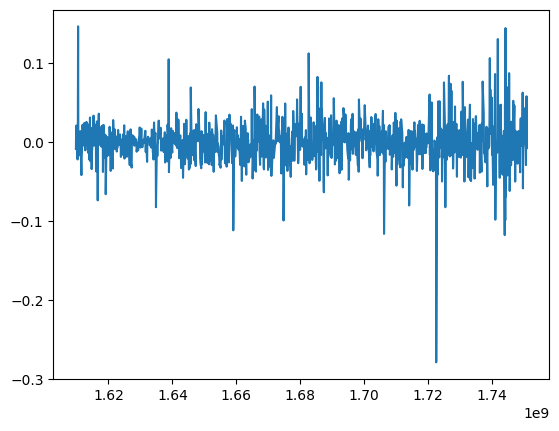

In [324]:
#root_dir = "/Users/silas/work/machine_learning/LSTM/data/data_dump"
root_dir = "../data/data_dump"
stock_data = StockDataset(root_dir, seq_len=1124)

stock_nr = 3

print(stock_data.files)
plt.plot(stock_data.data[stock_nr,-1,:], stock_data.data[stock_nr,0,:])

#abs_data = stock_data.recons_absol()
#plt.plot(abs_data[stock_nr,-1,:], abs_data[stock_nr,0,:])

#average = stock_data.average()
#plt.plot(average[stock_nr,-1,:], average[stock_nr,1,:])

In [325]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, target_stock_idx):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return self.data.shape[-1] - self.seq_len

    def __getitem__(self, idx):
        x = self.data[:, :, idx : idx + self.seq_len]
        y = self.data[:, target_stock_idx, idx + self.seq_len]
        return x, y

In [326]:
def split_time_series(data, train_ratio=0.7, val_ratio=0.15):
    time_steps = data.shape[-1]
    #print(f"Time steps: {time_steps}")
    train_end = int(time_steps * train_ratio)
    val_end = int(time_steps * (train_ratio + val_ratio))
    return data[:, :, 0:train_end], data[:, :, train_end:val_end], data[:, :, val_end:]

In [327]:
def get_warmup_cosine_scheduler(optimizer, warmup_steps, total_steps, lr_max):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return current_step / warmup_steps
        else:
            progress = (current_step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1 + math.cos(math.pi * progress))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

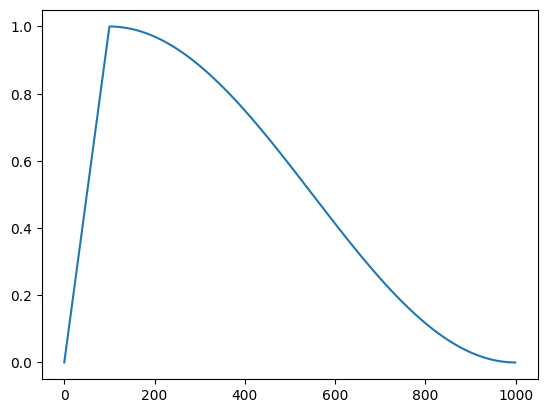

In [328]:
dummy_warmup_steps = 100
dummy_total_steps = 1000
dummy_lr = np.zeros(dummy_total_steps)
dummy_steps = np.arange(0, dummy_total_steps, 1)

for step in dummy_steps:
    if step < dummy_warmup_steps:
        dummy_lr[step] = step / dummy_warmup_steps
    else:
        progress = (step - dummy_warmup_steps) / (dummy_total_steps - dummy_warmup_steps)
        dummy_lr[step] = 0.5 * (1 + math.cos(math.pi * progress))

plt.plot(dummy_steps, dummy_lr)
plt.show()

In [329]:
in_size = len(stock_data.files)
data_pass = stock_data.data[:,:5,:]
target_stock_idx = 1 # [open, close, high, low, volume, datetime]
print(f"Stock dimension: {stock_data.data.shape}")
value_size = data_pass.shape[1]
print(f"Value size: {value_size}")

# lstm model parameters
num_lstms = 1
h_size = 8
n_layers = 2

pre_heads = 2
time_heads = 2
asset_heads = 2
meta_heads = 1

dropout = 0.3
seq_len = 64
batch_size = 128
deviation = (0.05, 0.0)

# training lstm model
warmup_steps = 50
total_steps = 200
lr_max=1e-4
weight_decay = 0

# After training parameters
threshold = 0.003

Stock dimension: (22, 7, 1124)
Value size: 5


In [330]:
train, val, test = split_time_series(data_pass, train_ratio=0.7, val_ratio=0.15)
print(f"Shapes: train={train.shape} val={val.shape} test={test.shape}")

train_ds = TimeSeriesDataset(train, seq_len, target_stock_idx)
val_ds = TimeSeriesDataset(val, seq_len, target_stock_idx)
test_ds = TimeSeriesDataset(test, seq_len, target_stock_idx)
#print(f"Shapes: train={train.shape} val={val.shape} test={test.shape}")

# (Batch, in_size, seq_len)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

Shapes: train=(22, 5, 786) val=(22, 5, 169) test=(22, 5, 169)


In [331]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
print(f"device: {device}")

device: cpu


In [332]:
model = LSTM(in_size, h_size, n_layers, batch_size, seq_len, pre_heads, 
             time_heads, asset_heads, meta_heads, value_size, num_lstms, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_max, weight_decay=weight_decay)
scheduler = get_warmup_cosine_scheduler(optimizer, warmup_steps=warmup_steps, total_steps=total_steps, lr_max=lr_max)

In [333]:
def calc_correct_preds(test_data, mu, sigma, nu, threshold):

    sigma = np.where(nu > 2, np.sqrt(nu / (nu-2)) * sigma, 1e10)
    
    # signal to noise ratio
    s_n = np.abs(mu) / sigma

    significant_out = np.where(s_n > threshold, np.where(mu > 0, 1, -1), 0.)

    samples = np.sum((significant_out * test_data) != 0)
    correct_sign = np.sum((significant_out * test_data) > 0.)

    return samples, correct_sign

In [334]:
def calc_alloc_return(
    mu, sigma, nu, skew, real_returns,
    cash_threshold=0.3,
    temp=1.0,
    apply_confidence_mask=True,
    min_snr=0.1,
    invest_sigmoid_scale=10.0,
    allow_short=True
):
    """
    Compute softmax portfolio allocation based on signal-to-noise from a Student-t prediction.

    Args:
        mu: Predicted mean [B, N]
        sigma: Predicted scale [B, N]
        nu: Predicted degrees of freedom [B, N]
        real_returns: Realized returns [B, N]
        cash_threshold: SNR assigned to 'do nothing' cash asset
        temp: Temperature for softmax smoothing
        apply_confidence_mask: If True, filters weak signals
        min_snr: Minimum SNR to include an asset
        invest_sigmoid_scale: How quickly investment ratio rises with signal
        allow_short: If True, will flip returns for negative `mu`

    Returns:
        allocations: Final allocations [B, N+1]
        port_ret: Realized return for each batch [B]
    """
    batch_size, n_assets = mu.shape

    # Add 'cash' asset (mu=0, sigma=1, nu=inf, return=0)
    mu = torch.cat([mu, torch.zeros(batch_size, 1, device=mu.device)], dim=1)
    sigma = torch.cat([sigma, torch.ones(batch_size, 1, device=sigma.device)], dim=1)
    nu = torch.cat([nu, torch.full((batch_size, 1), float('inf'), device=nu.device)], dim=1)
    skew = torch.cat([skew, torch.full((batch_size, 1), 0, device=skew.device)], dim=1)
    real_returns = torch.cat([real_returns, torch.zeros(batch_size, 1, device=real_returns.device)], dim=1)

    # Adjust sigma using t-distribution variance (only if nu > 2)
    t_var_scale = torch.sqrt(nu / (nu - 2).clamp(min=1.01))  # Prevent division by zero
    adj_sigma = sigma * t_var_scale

    mu_adj = mu + skew * adj_sigma  # crude skew-adjusted mean
    snr = torch.abs(mu_adj**2) / adj_sigma
    
    # Set fixed SNR for cash asset to control abstention
    snr[:, -1] = cash_threshold

    # Optional: confidence mask to suppress low SNR signals
    if apply_confidence_mask:
        snr_mask = (snr > min_snr).float()
        snr = snr * snr_mask  # suppress weak signals

    # Softmax over SNR to get allocation weights
    alloc_raw = F.softmax(snr / temp, dim=-1)  # [B, N+1]

    # Optional: adaptive investment ratio based on confidence in best asset
    max_signal = snr[:, :-1].max(dim=1, keepdim=True)[0]  # exclude cash
    invest_ratio = torch.sigmoid((max_signal - cash_threshold) * invest_sigmoid_scale)  # [B, 1]

    # Scale total investment intensity (cash gets residual)
    allocations = alloc_raw * invest_ratio  # [B, N+1]

    # Compute portfolio returns
    if allow_short:
        # Flip returns based on sign of mu
        directional_returns = torch.where(mu > 0, real_returns, -real_returns)
    else:
        # Long-only
        directional_returns = real_returns * (mu > 0).float()

    port_ret = (allocations * directional_returns).sum(dim=1)  # [B]

    return allocations, port_ret

In [ ]:
# Train LSTM model
for step in range(total_steps):
    
    # Training
    model.train()
    train_loss = 0
    
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # train stock predictor
        optimizer.zero_grad()
        mu, sigma, nu, skew = model(batch_x)
        loss = skewed_student_t_loss(mu, sigma, nu, skew, batch_y, deviation)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    scheduler.step()
    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0

    samples = 0
    correct_sign = 0
    
    for val_x, val_y in val_loader:
        val_x = val_x.to(device)
        val_y = val_y.to(device)

        mu, sigma, nu, skew = model(val_x)
        loss = skewed_student_t_loss(mu, sigma, nu, skew, val_y, deviation)

        val_loss += loss.item()

        # <=== Test correct up down predictions ===>
        val_y = val_y.to("cpu").detach().numpy()
        sigma = sigma.to("cpu").detach().numpy()
        mu = mu.to("cpu").detach().numpy()
        nu = nu.to("cpu").detach().numpy()

        sam, corr = calc_correct_preds(val_y, mu, sigma, nu, threshold)
        samples += sam
        correct_sign += corr

    avg_val_loss = val_loss / len(val_loader)
    correct_sign_ratio = correct_sign / samples

    if (step % 25 == 24):
        print(f"Step              : {step+1}/{total_steps}")
        print(f"LR in millions    : {scheduler.get_last_lr()[0]*10e6:.3f}")
        print(f"Train Loss        : {avg_train_loss:.4f}")
        print(f"Validation Loss   : {avg_val_loss:.4f}")
        print(f"Correct sign ratio: {correct_sign_ratio*100:.1f}%")
        print(f"Significant points: {samples}")
        print()

Step              : 25/200
LR in millions    : 500.000
Train Loss        : 0.8894
Validation Loss   : 0.8722
Correct sign ratio: 51.3%
Significant points: 2195

Step              : 50/200
LR in millions    : 1000.000
Train Loss        : -1.9107
Validation Loss   : -1.9682
Correct sign ratio: 50.5%
Significant points: 2299

Step              : 75/200
LR in millions    : 933.013
Train Loss        : -2.4619
Validation Loss   : -2.4935
Correct sign ratio: 50.5%
Significant points: 2299

Step              : 100/200
LR in millions    : 750.000
Train Loss        : -2.4700
Validation Loss   : -2.4930
Correct sign ratio: 50.5%
Significant points: 2299



In [ ]:
def compute_performance_metrics(returns, n_bootstrap=1000, ci=0.95):
    """
    Computes metrics and confidence intervals via bootstrapping.
    Args:
        returns: array-like, daily returns
        n_bootstrap: number of resampling iterations
        ci: confidence level (default: 95%)
    Returns:
        Dict of metric -> (mean, lower_ci, upper_ci)
    """
    returns = np.array(returns)
    alpha = 1 - ci
    metrics = {
        'daily_return': [],
        'cumulative_return': [],
        'annualized_return': [],
        'sharpe_ratio': [],
        'max_drawdown': []
    }

    for _ in range(n_bootstrap):
        sample = np.random.choice(returns, size=len(returns), replace=True)

        # === Metrics ===
        mean_r = np.mean(sample)
        std_r = np.std(sample)
        sharpe = mean_r / (std_r + 1e-8) * np.sqrt(252)

        # Cumulative equity curve
        equity = np.cumprod(1 + sample)
        cum_return = equity[-1] - 1
        annual_ret = (equity[-1])**(252 / len(sample)) - 1

        # Drawdown
        peak = np.maximum.accumulate(equity)
        dd = (equity - peak) / peak
        max_dd = dd.min()

        # Store
        metrics['daily_return'].append(mean_r)
        metrics['cumulative_return'].append(cum_return)
        metrics['annualized_return'].append(annual_ret)
        metrics['sharpe_ratio'].append(sharpe)
        metrics['max_drawdown'].append(max_dd)

    # Compute CI bounds
    def summarize(metric_values):
        mean_val = np.mean(metric_values)
        lower = np.percentile(metric_values, 100 * alpha / 2)
        upper = np.percentile(metric_values, 100 * (1 - alpha / 2))
        return mean_val, lower, upper

    return {k: summarize(v) for k, v in metrics.items()}

In [ ]:
################################################
################################################
################## Analyze #####################
################################################
################################################

"""
'sharpe'
'annualized_return'
'cumulative_return'
'max_drawdown'
'combined'
"""

optimized_by = 'annualized_return'

def sample_random_params():
    return {
        "cash_threshold": uniform(0.0, 0.05),
        "temp": uniform(0.001, 0.05),
        "min_snr": uniform(0.0, 0.1),
        "invest_sigmoid_scale": uniform(1.0, 20.0)
    }

def evaluate_config(model, val_loader, config):
    all_returns = []
    model.eval()
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x, val_y = val_x.to(device), val_y.to(device)
            mu, sigma, nu, skew = model(val_x)

            _, port_ret = calc_alloc_return(
                mu, sigma, nu, skew, val_y,
                cash_threshold=config['cash_threshold'],
                temp=config['temp'],
                apply_confidence_mask=True,
                min_snr=config['min_snr'],
                invest_sigmoid_scale=config['invest_sigmoid_scale'],
                allow_short=True
            )

            returns = port_ret.detach().cpu().numpy().flatten()
            all_returns.extend(returns)

    r = np.array(all_returns)
    if len(r) < 10:  # not enough points for reliable metrics
        return None

    # Metrics
    equity = np.cumprod(1 + r)
    cumulative_return = equity[-1] - 1
    annualized = (equity[-1])**(252 / len(r)) - 1
    sharpe = np.mean(r) / (np.std(r) + 1e-8) * np.sqrt(252)
    max_dd = (equity - np.maximum.accumulate(equity)) / np.maximum.accumulate(equity)
    drawdown = max_dd.min()

    return {
        'sharpe': sharpe,
        'annualized_return': annualized,
        'cumulative_return': cumulative_return,
        'max_drawdown': drawdown,
        'samples': len(r),
        'combined': 0.5 * sharpe + 2 * annualized - 1 * abs(drawdown)
    }

n_trials = 500
results = []

for _ in tqdm(range(n_trials)):
    params = sample_random_params()
    metrics = evaluate_config(model, val_loader, params)
    if metrics:
        results.append({
            **params,
            **metrics
        })

# Sort by Sharpe ratio
sorted_results = sorted(results, key=lambda x: x[optimized_by], reverse=True)

# Best configuration
best = sorted_results[0]
value_arr = np.zeros(len(best))
print("\nBest configuration:")
for i, (k, v) in enumerate(best.items()):
    print(f"{k:20s}: {v:.4f}")
    value_arr[i] = v

In [ ]:
best_cash_threshold, best_temp, best_min_snr, best_invest_sigmoid_scale = value_arr[0:4]

all_returns = []  # Store all daily returns in time order

total_ret, sample_count = 0, 0
for test_x, test_y in test_loader:
    test_x, test_y = test_x.to(device), test_y.to(device)
    mu, sigma, nu, skew = model(test_x)

    # === Apply current threshold to get allocation and returns ===
    alloc, port_ret = calc_alloc_return(
        mu, sigma, nu, skew, test_y,
        cash_threshold=best_cash_threshold,
        temp=best_temp,
        apply_confidence_mask=True,
        min_snr=best_min_snr,
        invest_sigmoid_scale=best_invest_sigmoid_scale,
        allow_short=True
    )

    total_ret += port_ret.sum().item()
    sample_count += port_ret.shape[0]

    all_returns.extend(port_ret.detach().cpu().numpy().flatten())

avg_daily_ret = total_ret / sample_count
annual_ret = ((avg_daily_ret + 1)**252 - 1) * 100  # Trading year ≈ 252 days

# Convert to numpy array
all_returns = np.array(all_returns)  # shape: [n_days]

# Cumulative equity (compound growth)
equity_curve = np.cumprod(1 + all_returns)

# Annualized return
annualized_return = (equity_curve[-1]) ** (252 / len(equity_curve)) - 1

# Sharpe ratio (assume 0% risk-free rate)
sharpe_ratio = np.mean(all_returns) / (np.std(all_returns) + 1e-8) * np.sqrt(252)

# Max drawdown
rolling_max = np.maximum.accumulate(equity_curve)
drawdowns = (equity_curve - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

print(f"\n<========== Final Test Performance ==========>")
#print(f"Daily return @ threshold={final_th:.3f}: {avg_daily_ret*100:.3f}%")
#print(f"Annualized return: {annual_ret:.2f}%")
#print()
print(f"Final cumulative return: {equity_curve[-1] - 1:.2%}")
print(f"Annualized return: {annualized_return:.2%}")
print(f"Sharpe ratio: {sharpe_ratio:.2f}")
print(f"Max drawdown: {max_drawdown:.2%}")

print(f"\n<========== S&P 500 Performance ==========>")
print(f"Final cumulative return: {0.285 * len(equity_curve) / 390:.2%}")
print(f"Annualized return: 18.9%")
print(f"Sharpe ratio: 1.40")
print(f"Max drawdown: -8%")
print()
print(f"Optimized by: {optimized_by}")
print(f"Number of samples: {len(equity_curve)}")

print(f"\n<========== Bootstrap results ==========>")
results = compute_performance_metrics(all_returns, n_bootstrap=1000, ci=0.95)
for name, (mean_val, low, high) in results.items():
    print(f"{name.replace('_', ' ').title()}: {mean_val*100:.2f}% "
          f"[{low*100:.2f}%, {high*100:.2f}%]")

#print(alloc[0,:])